Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Data Augmentation

In [2]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_set, val_set = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)


Model

In [ ]:
class CNN12(nn.Module):
    def __init__(self):
        super(CNN12, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            # Block 4 
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 2x2
            nn.Dropout(0.5)


        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024), nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512), nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256), nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


Train the Model

In [5]:
import torch
import copy

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=15, patience=3):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss_epoch = total_loss / len(train_loader)
        train_acc_epoch = 100 * correct / total
        train_loss.append(train_loss_epoch)
        train_acc.append(train_acc_epoch)

        val_l, val_a = evaluate(model, val_loader, criterion, device)
        val_loss.append(val_l)
        val_acc.append(val_a)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss_epoch:.4f} | Train Acc: {train_acc_epoch:.2f}% | "
              f"Val Loss: {val_l:.4f} | Val Acc: {val_a:.2f}%")

        # Early Stopping Check
        if val_l < best_val_loss:
            best_val_loss = val_l
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss, train_acc, val_acc


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN12().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    epochs=20, patience=4
)


Epoch [1/20] Train Loss: 1.7197 | Train Acc: 35.33% | Val Loss: 1.3889 | Val Acc: 49.20%
Epoch [2/20] Train Loss: 1.3005 | Train Acc: 53.35% | Val Loss: 1.1218 | Val Acc: 59.68%
Epoch [3/20] Train Loss: 1.1228 | Train Acc: 60.24% | Val Loss: 1.0296 | Val Acc: 63.55%
Epoch [4/20] Train Loss: 0.9930 | Train Acc: 65.40% | Val Loss: 1.0242 | Val Acc: 64.57%
Epoch [5/20] Train Loss: 0.8981 | Train Acc: 69.06% | Val Loss: 0.7780 | Val Acc: 72.55%
Epoch [6/20] Train Loss: 0.8300 | Train Acc: 71.74% | Val Loss: 0.7209 | Val Acc: 74.94%
Epoch [7/20] Train Loss: 0.7703 | Train Acc: 73.87% | Val Loss: 0.6572 | Val Acc: 77.06%
Epoch [8/20] Train Loss: 0.7283 | Train Acc: 75.37% | Val Loss: 0.6519 | Val Acc: 77.54%
Epoch [9/20] Train Loss: 0.6914 | Train Acc: 76.87% | Val Loss: 0.6270 | Val Acc: 78.66%
Epoch [10/20] Train Loss: 0.6563 | Train Acc: 78.03% | Val Loss: 0.6201 | Val Acc: 78.19%
Epoch [11/20] Train Loss: 0.6239 | Train Acc: 79.09% | Val Loss: 0.5370 | Val Acc: 81.87%
Epoch [12/20] Train

Test accuracy

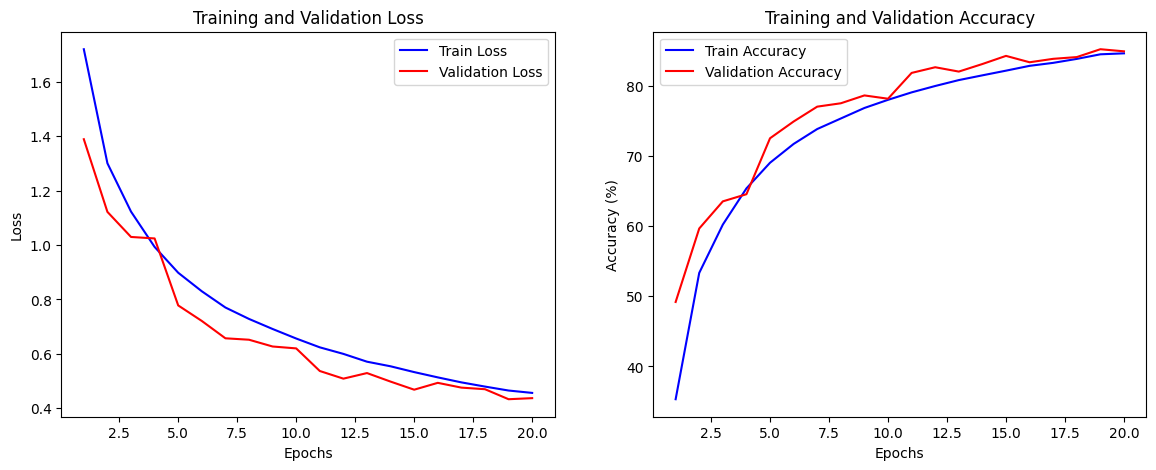

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


plot_training_history(train_loss, val_loss, train_acc, val_acc)

Confusion Matrix


Test Accuracy: 86.84%


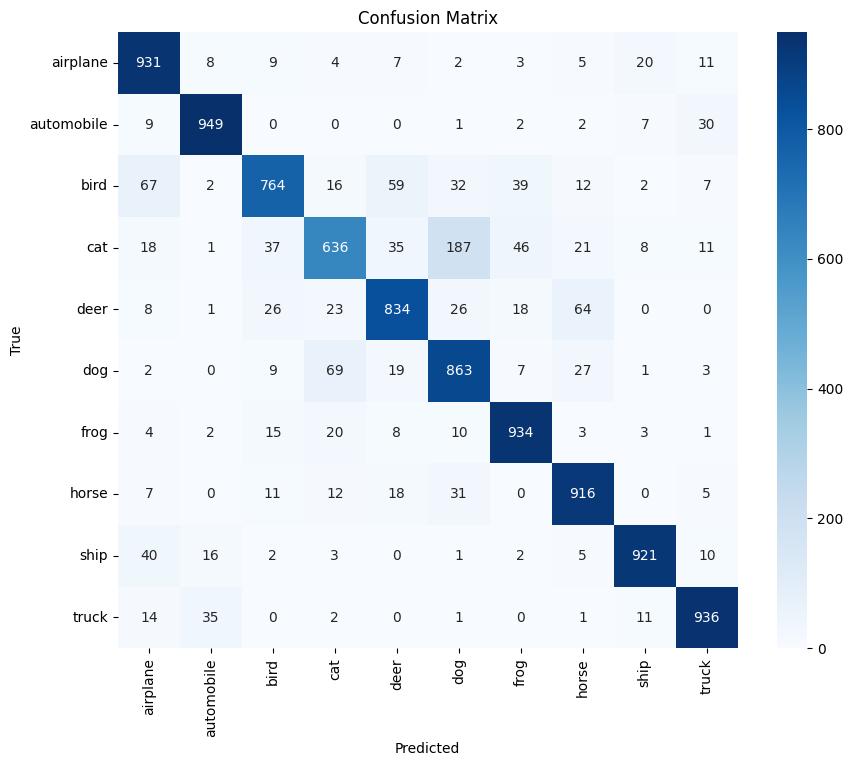

In [14]:
def test_and_confusion(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nTest Accuracy: {acc * 100:.2f}%")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.xlabel("Predicted"), plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

test_and_confusion(model, test_loader)


ROC AND AUC CURVE and Precision and recall of all classes

Class-wise Precision, Recall and F1-Score:
airplane: Precision=0.846, Recall=0.931, F1-score=0.887
automobile: Precision=0.936, Recall=0.949, F1-score=0.942
bird: Precision=0.875, Recall=0.764, F1-score=0.816
cat: Precision=0.810, Recall=0.636, F1-score=0.713
deer: Precision=0.851, Recall=0.834, F1-score=0.842
dog: Precision=0.748, Recall=0.863, F1-score=0.801
frog: Precision=0.889, Recall=0.934, F1-score=0.911
horse: Precision=0.867, Recall=0.916, F1-score=0.891
ship: Precision=0.947, Recall=0.921, F1-score=0.934
truck: Precision=0.923, Recall=0.936, F1-score=0.929


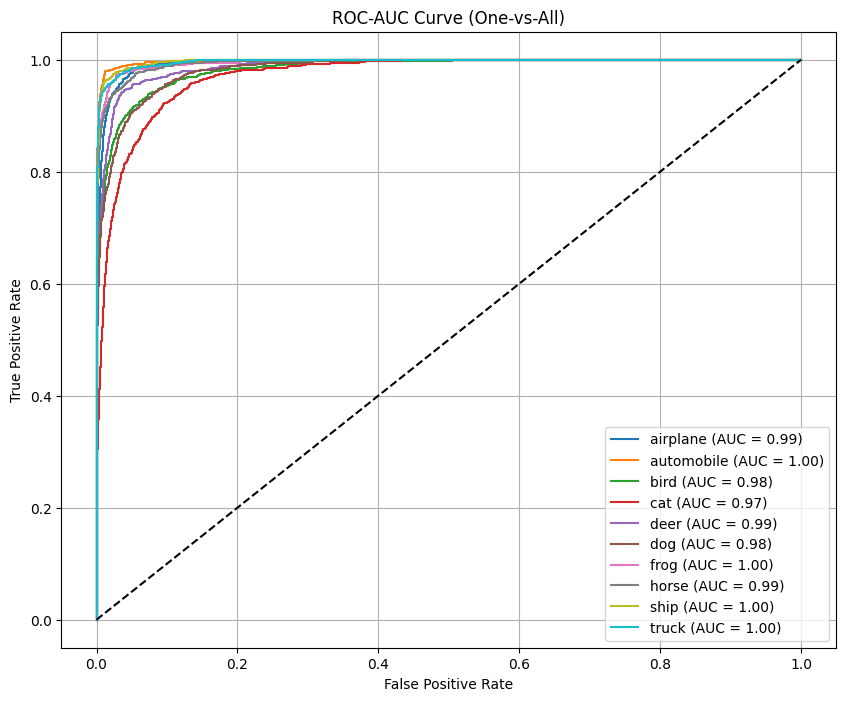

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def test_metrics_and_roc(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []
    y_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Per-class precision, recall, f1
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_names)))

    print("Class-wise Precision, Recall and F1-Score:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={f1[i]:.3f}")

    # ROC-AUC per class (one-vs-all)
    y_true_bin = np.eye(len(class_names))[y_true]  # one-hot encoding

    plt.figure(figsize=(10,8))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # random guess line
    plt.title("ROC-AUC Curve (One-vs-All)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

test_metrics_and_roc(model, test_loader, test_data.classes)


Precision Recall Curve

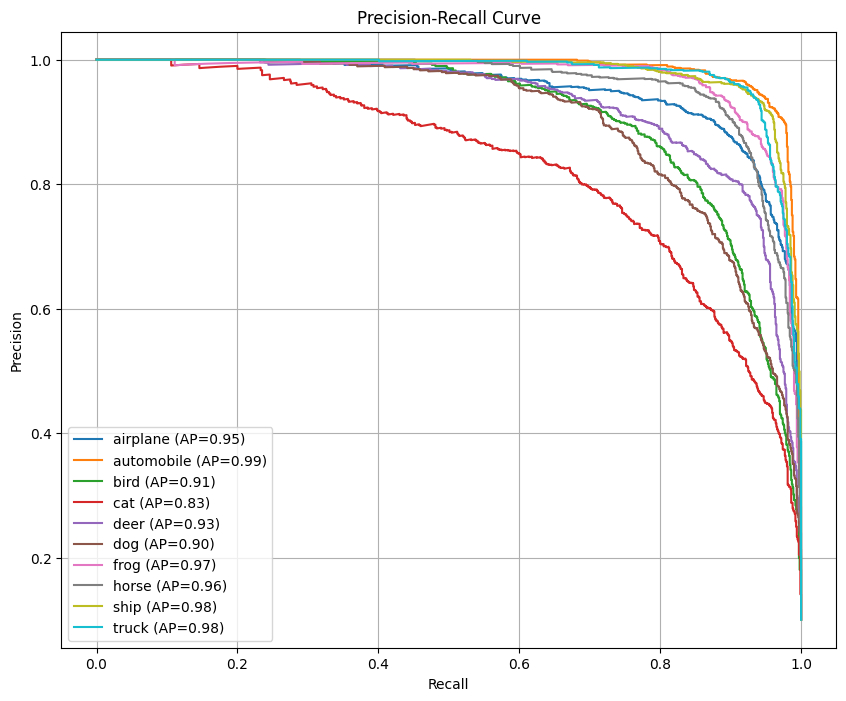

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve(model, data_loader, class_names, device):
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    y_true_bin = np.eye(len(class_names))[y_true]  # One-hot encoding

    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(class_names):
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        ap_score = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall_curve, precision_curve, label=f"{cls} (AP={ap_score:.2f})")

    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


# plot_precision_recall_curve(model, test_loader, test_data.classes, device)
plot_precision_recall_curve(model, test_loader, test_data.classes, device)